<h1> Evaluation of a dataset + a model</h1>

In this notebook we focus on the fairness evaluation of a couple (dataset, model). </br>
We use two libraries : dalex and aif360.

In [603]:
#! pip install -U scikit-learn
import pandas as pd
import numpy as np
from copy import copy

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier

In [696]:
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

import dalex as dx
import numpy as np
import pandas as pd
import sklearn

from aif360.datasets import BinaryLabelDataset
from aif360.datasets import StructuredDataset
from aif360.metrics import ClassificationMetric

In [697]:
#! pip install dalex
import dalex as dx

#! pip install aif360 tensorflow
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import ClassificationMetric

In [698]:
#! pip install fairlearn
import fairlearn
from aif360.sklearn.inprocessing import AdversarialDebiasing

<h3> New test: adversarial learning </h3>

In [829]:
tf.random.set_random_seed(42)

In [830]:
df, target = dx.datasets.load_german(), "risk"

In [831]:
df["job"] = df["job"].astype("object")
df["sex"] = np.where(df["sex"] == "female", 1, 0).astype(np.int64)
df["youth"] = np.where(df.age <= 25, 1, 0).astype(np.int64)

In [832]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=[target]),
    df[target],
    test_size=0.3,
    random_state=42
)

In [833]:
class ToFrame():
    def __init__(self):
        pass
        #print('ok')
    
    def fit(self, arr, y=None):
        return self
    
    def transform(self, arr, y=None):
        df = pd.DataFrame(arr)
        df.columns = columns_names
        df.index = df['passthrough__youth']
        #print(df.head())
        return df

In [834]:
preprocessor = make_column_transformer(
      ("passthrough", make_column_selector(dtype_include=np.number)),
      (OneHotEncoder(handle_unknown="ignore"), make_column_selector(dtype_include=object)),
)

X_prep_train =  preprocessor.fit_transform(X_train)
columns_names = preprocessor.get_feature_names_out(preprocessor.feature_names_in_)

In [835]:
models = []
for adv_weight in ['no_adv', 'adv']:
    if adv_weight == 'no_adv':
        models.append(
            
                        Pipeline(steps=[
                            ('preprocessor', preprocessor),
                            ('toframe', ToFrame()),
                            ('classifier', DecisionTreeClassifier(max_depth=7, random_state=123))
                        ])       
                     )
    else:
        models.append(
                    Pipeline(steps=[
                        ('preprocessor', preprocessor),
                        ('toframe', ToFrame()),
                        ('adv', AdversarialDebiasing(prot_attr='passthrough__youth', 
                                                     debias=True
                                                    ))
                            ])        
                 )

In [836]:
models_expl = []
for model in models:
    model.fit(X_train, y_train)
    models_expl.append(
                        dx.Explainer(model, X_test, y_test, verbose=False)
    )    

In [837]:
protected = np.where(X_test.age <= 25, 'young', 'old')  # X_test.sex.astype("str") 
privileged = 'old'

In [838]:
fobj = []
for i, expl in enumerate(models_expl):
    fobj.append(
                expl.model_fairness(protected=protected, privileged=privileged)
    )
    fobj[-1].label ='adv_{}'.format(i)

In [839]:
fobj[0].fairness_check()

Bias detected in 4 metrics: TPR, ACC, FPR, STP

Conclusion: your model is not fair because 2 or more criteria exceeded acceptable limits set by epsilon.

Ratios of metrics, based on 'old'. Parameter 'epsilon' was set to 0.8 and therefore metrics should be within (0.8, 1.25)
        TPR       ACC      PPV       FPR       STP
young  0.57  0.786908  0.94695  0.473469  0.529894


In [840]:
fobj[1].fairness_check()

No bias was detected!

Conclusion: your model is fair in terms of checked fairness criteria.

Ratios of metrics, based on 'old'. Parameter 'epsilon' was set to 0.8 and therefore metrics should be within (0.8, 1.25)
       TPR       ACC       PPV  FPR  STP
young  1.0  0.880952  0.880952  1.0  1.0


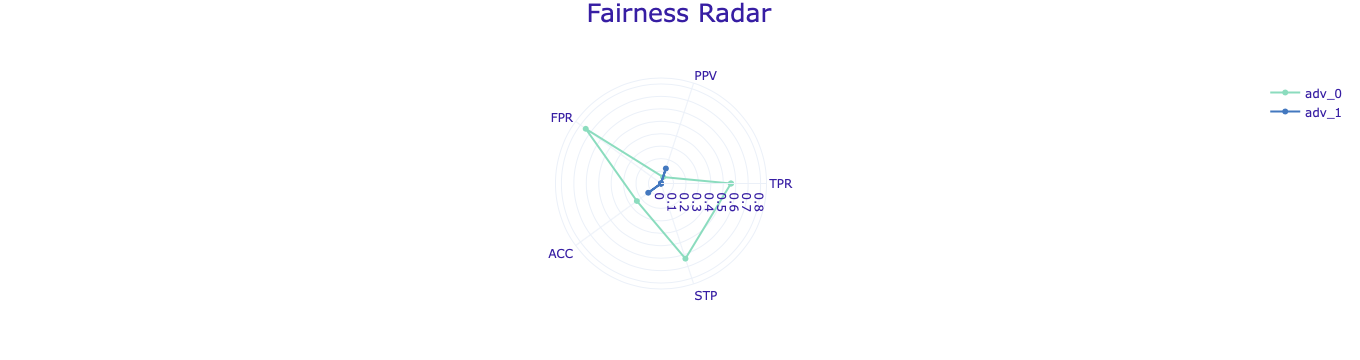

In [844]:
fobj[0].plot(objects=[fobj[1]], type = "radar")  # performance_and_fairness

In [84]:
X_trans

array([[0.000e+00, 2.032e+03, 2.400e+01, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [0.000e+00, 1.884e+03, 1.200e+01, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.000e+00, 3.622e+03, 3.000e+01, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       ...,
       [0.000e+00, 5.804e+03, 2.400e+01, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [0.000e+00, 1.484e+03, 1.200e+01, ..., 1.000e+00, 0.000e+00,
        0.000e+00],
       [1.000e+00, 9.320e+02, 6.000e+00, ..., 1.000e+00, 0.000e+00,
        0.000e+00]])

In [80]:
import tensorflow.compat.v1 as tf

In [81]:
sess = tf.Session()

In [82]:
tf.disable_eager_execution()
adv_model.fit(X_train, y_train)

TypeError: fit() takes 2 positional arguments but 3 were given

In [36]:
X_prep_train =  preprocessor.fit_transform(X_train)

columns_names = preprocessor.get_feature_names_out(preprocessor.feature_names_in_)
X_prep_train = pd.DataFrame(X_prep_train, columns=columns_names)

privileged_groups=[{'passthrough_sex': 0}]
unprivileged_groups=[{'passthrough_sex': 1}]

In [37]:
X_prep_train.index = X_prep_train['passthrough__sex']

In [38]:
X_prep_train.index

Float64Index([0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0,
              ...
              1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
             dtype='float64', name='passthrough__sex', length=700)

In [14]:
from aif360.sklearn.inprocessing import AdversarialDebiasing
import tensorflow.compat.v1 as tf

In [25]:
sess = tf.Session()
adv_model = AdversarialDebiasing(prot_attr='passthrough__sex',
    debias=True)

In [26]:
tf.disable_eager_execution()
adv_model.fit(X_prep_train, y_train)

AdversarialDebiasing(prot_attr='passthrough__sex')

In [27]:
(adv_model.predict(X_prep_train) == y_train).mean()

0.7014285714285714

In [ ]:
adv_model.fit()

In [62]:
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_adult, load_preproc_data_compas, load_preproc_data_german

In [ ]:
binary_dataset_gt = BinaryLabelDataset(df=data_for_aif_gt, label_names=['risk'], protected_attribute_names=['sex', 'age'])
binary_dataset_pred = BinaryLabelDataset(df=data_for_aif_pred, label_names=['risk'], protected_attribute_names=['sex', 'age'])

In [ ]:
X_prep_train, X_prep_test = preprocessor.fit_transform(X_train), preprocessor.transform(X_test)
column_names = preprocessor.get_feature_names_out(preprocessor.feature_names_in_)

df_prep = pd.DataFrame(X_prep_train)
df_prep.columns = column_names

df_prep['risk'] = np.array(y_train)

privileged_groups=[{'onehotencdore_sex_male': 1.0}]
unprivileged_groups=[{'onehotencdore_sex_female': 1.0}]

#df_prep

<h4> Load the dataset and train the model</h4>

In [112]:
# load the original dataset 
# data = pd.read_csv("https://raw.githubusercontent.com/ekimetrics/ethical-ai-toolkit/main/data/german-risk-scoring.csv")

# load a clean version of the german risk scoring dataset
data = dx.datasets.load_german()
data.head()

,risk,sex,job,housing,saving_accounts,checking_account,credit_amount,duration,purpose,age
0,1,male,2,own,not_known,little,1169,6,radio/TV,67
1,0,female,2,own,little,moderate,5951,48,radio/TV,22
2,1,male,1,own,little,not_known,2096,12,education,49
3,1,male,2,free,little,little,7882,42,furniture/equipment,45
4,0,male,2,free,little,little,4870,24,car,53


In [144]:
X = data.drop(columns='risk')
y = data.risk

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', 'passthrough', numerical_features)
])

clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(max_depth=7, random_state=123))
])

clf.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sex', 'job', 'housing',
                                                   'saving_accounts',
                                                   'checking_account',
                                                   'purpose']),
                                                 ('num', 'passthrough',
                                                  ['age', 'duration',
                                                   'credit_amount'])])),
                ('classifier',
                 DecisionTreeClassifier(max_depth=7, random_state=123))])

<h4> Extract fairness metrics </h4>

The first step is to define the sensitive attributes on which we wish to evaluate fairness. Then, each library automatically compute a bunch of fairness metrics.
<ul>
    <li> With dalex, first wrap the "model + dataset" in an Explainer object and then apply the method model_fairness. This returns a GroupFairnessClassification object which has already computed all the mtrics and which can either give a fairness_check or a plot.</li>
    <li> With aif360, first wrap the dataset with groundtruth labels and the dataset with predicted labels in two BinaryLabelDataset objects, then wrap the "BinaryLabelDataset_groundtruth + BinaryLabelDataset_predicted" in an ClassificationMetric object. This object has several methods that compute fairness metrics.
</ul>

In [145]:
explainer = dx.Explainer(clf, X, y, verbose=False)

protected = data.sex + '_' + np.where(data.age < 25, 'young', 'old')
privileged = 'male_old'

fairness_object = explainer.model_fairness(protected = protected, privileged=privileged)

In [146]:
fairness_object.fairness_check(epsilon = 0.8)

No bias was detected!

Conclusion: your model is fair in terms of checked fairness criteria.

Ratios of metrics, based on 'male_old'. Parameter 'epsilon' was set to 0.8 and therefore metrics should be within (0.8, 1.25)
                   TPR       ACC       PPV       FPR       STP
female_old    1.018828  1.000000  0.971963  0.921525  0.964677
female_young  0.981172  0.938824  0.891355  0.872197  0.855055
male_young    1.019874  0.977647  0.929907  0.896861  0.918392


In [151]:
fairness_object.metric_scores

,TPR,TNR,PPV,NPV,FNR,FPR,FDR,FOR,ACC,STP
female_old,0.974,0.589,0.832,0.915,0.026,0.411,0.168,0.085,0.850,0.792
female_young,0.938,0.611,0.763,0.880,0.062,0.389,0.237,0.120,0.798,0.702
male_old,0.956,0.554,0.856,0.821,0.044,0.446,0.144,0.179,0.850,0.821
male_young,0.975,0.600,0.796,0.938,0.025,0.400,0.204,0.062,0.831,0.754



Found NaN's or 0's for models: {'DecisionTreeClassifier'}
It is advisable to check 'metric_ratios'


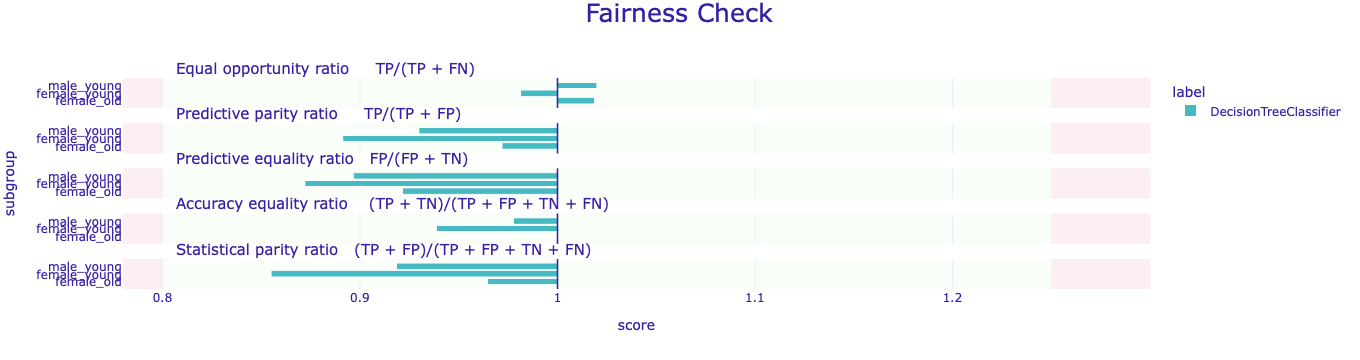

In [147]:
fairness_object.plot()

In [189]:
data.head()
data_for_aif = X[['sex']]
data_for_aif['sex'] = data_for_aif['sex'].apply(lambda x: int(x == 'male'))
data_for_aif['age'] = X['age'].apply(lambda x: int(x >= 25))

y_pred = clf.predict(X)

data_for_aif_gt = copy(data_for_aif)
data_for_aif_pred = copy(data_for_aif)
data_for_aif_gt['risk'] = y
data_for_aif_pred['risk'] = y_pred

In [204]:
binary_dataset_gt = BinaryLabelDataset(df=data_for_aif_gt, label_names=['risk'], protected_attribute_names=['sex', 'age'])
binary_dataset_pred = BinaryLabelDataset(df=data_for_aif_pred, label_names=['risk'], protected_attribute_names=['sex', 'age'])

In [214]:
aif_classif_metrics = ClassificationMetric(binary_dataset_gt, 
                                           binary_dataset_pred, 
                                           privileged_groups=[{'sex': 1.0, 'age': 1.0}],
                                           unprivileged_groups=[{'sex': 1.0, 'age': 0.0}, {'sex': 0.0, 'age': 1.0}, {'sex': 0.0, 'age': 0.0}]
                                          )

In [215]:
aif_classif_metrics.disparate_impact()

0.9281045751633987